# "Pairs Trading on the Mexican IRS Curve"

Topic: Arbitrage Trading Strategy Design & Backtest

Jan/2018

by Enrique Reyes Díaz
19 July 2018 

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

/Users/ereyesdiaz/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Import Mexican Interest Rate Swaps (IRS TIIE) database:

In [2]:
data=pd.read_csv("./MXN_IRS.csv")

In [3]:
data.head()

,Date,3M,6M,9M,1Y,2Y,3Y,4Y,5Y,7Y,10Y,15Y,20Y
0,04/01/16,3.580,3.69,3.81,3.930,4.380,4.785,5.16,5.48,5.960,6.340,6.775,6.980
1,05/01/16,3.580,3.68,3.79,3.900,4.335,4.735,5.12,5.42,5.905,6.290,6.725,6.925
2,06/01/16,3.580,3.68,3.77,3.885,4.315,4.700,5.07,5.40,5.865,6.265,6.700,6.930
3,07/01/16,3.570,3.67,3.77,3.870,4.290,4.695,5.06,5.37,5.855,6.260,6.695,6.925
4,08/01/16,3.575,3.68,3.78,3.880,4.300,4.685,5.04,5.34,5.820,6.240,6.685,6.890


We can build a new dataframe and calculate a set of pair spreads to start our analysis:

In [4]:
columns=['Date','1/2','1/3','1/4','1/5','2/3','2/4','2/5','2/7','2/10','3/4','3/5','3/7','3/10',
         '4/5','4/7','4/10','5/7','5/10','5/15','5/20','7/10','7/20','10/15','10/20','15/20']
dfpairs=pd.DataFrame(index=data.index,columns=columns) # Create new DataFrame for Pairs
dfpairs['Date']=data['Date']
dfpairs['1/2']=data['2Y']-data['1Y']
dfpairs['1/3']=data['3Y']-data['1Y']
dfpairs['1/4']=data['4Y']-data['1Y']
dfpairs['1/5']=data['5Y']-data['1Y']
dfpairs['2/3']=data['3Y']-data['2Y']
dfpairs['2/4']=data['4Y']-data['2Y']
dfpairs['2/5']=data['5Y']-data['2Y']
dfpairs['2/7']=data['7Y']-data['2Y']
dfpairs['2/10']=data['10Y']-data['2Y']
dfpairs['3/4']=data['4Y']-data['3Y']
dfpairs['3/5']=data['5Y']-data['3Y']
dfpairs['3/7']=data['7Y']-data['3Y']
dfpairs['3/10']=data['10Y']-data['3Y']
dfpairs['4/5']=data['5Y']-data['4Y']
dfpairs['4/7']=data['7Y']-data['4Y']
dfpairs['4/10']=data['10Y']-data['4Y']
dfpairs['5/7']=data['7Y']-data['5Y']
dfpairs['5/10']=data['10Y']-data['5Y']
dfpairs['5/15']=data['15Y']-data['5Y']
dfpairs['5/20']=data['20Y']-data['5Y']
dfpairs['7/10']=data['10Y']-data['7Y']
dfpairs['7/20']=data['20Y']-data['7Y']
dfpairs['10/15']=data['15Y']-data['10Y']
dfpairs['10/20']=data['20Y']-data['10Y']
dfpairs['15/20']=data['20Y']-data['15Y']
dfpairs.head(10)

,Date,1/2,1/3,1/4,1/5,2/3,2/4,2/5,2/7,2/10,...,4/10,5/7,5/10,5/15,5/20,7/10,7/20,10/15,10/20,15/20
0,04/01/16,0.450,0.855,1.230,1.550,0.405,0.780,1.100,1.580,1.960,...,1.180,0.480,0.860,1.295,1.500,0.380,1.020,0.435,0.640,0.205
1,05/01/16,0.435,0.835,1.220,1.520,0.400,0.785,1.085,1.570,1.955,...,1.170,0.485,0.870,1.305,1.505,0.385,1.020,0.435,0.635,0.200
2,06/01/16,0.430,0.815,1.185,1.515,0.385,0.755,1.085,1.550,1.950,...,1.195,0.465,0.865,1.300,1.530,0.400,1.065,0.435,0.665,0.230
3,07/01/16,0.420,0.825,1.190,1.500,0.405,0.770,1.080,1.565,1.970,...,1.200,0.485,0.890,1.325,1.555,0.405,1.070,0.435,0.665,0.230
4,08/01/16,0.420,0.805,1.160,1.460,0.385,0.740,1.040,1.520,1.940,...,1.200,0.480,0.900,1.345,1.550,0.420,1.070,0.445,0.650,0.205
5,11/01/16,0.415,0.805,1.165,1.470,0.390,0.750,1.055,1.550,1.965,...,1.215,0.495,0.910,1.355,1.560,0.415,1.065,0.445,0.650,0.205
6,12/01/16,0.390,0.780,1.150,1.430,0.390,0.760,1.040,1.545,1.960,...,1.200,0.505,0.920,1.400,1.610,0.415,1.105,0.480,0.690,0.210
7,13/01/16,0.395,0.795,1.145,1.450,0.400,0.750,1.055,1.550,1.975,...,1.225,0.495,0.920,1.415,1.635,0.425,1.140,0.495,0.715,0.220
8,14/01/16,0.380,0.780,1.160,1.460,0.400,0.780,1.080,1.575,2.015,...,1.235,0.495,0.935,1.440,1.660,0.440,1.165,0.505,0.725,0.220
9,15/01/16,0.390,0.795,1.180,1.485,0.405,0.790,1.095,1.615,2.040,...,1.250,0.520,0.945,1.465,1.705,0.425,1.185,0.520,0.760,0.240


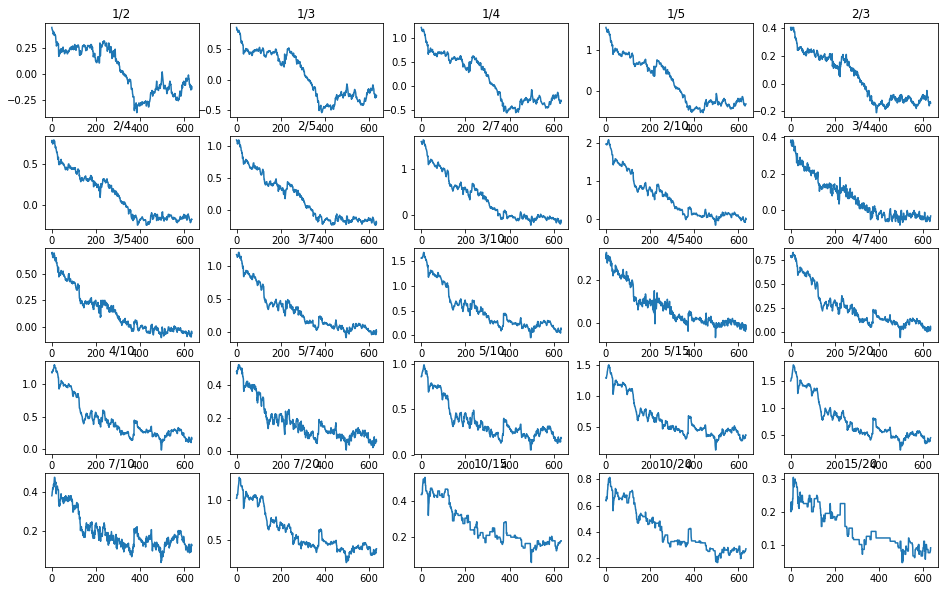

In [5]:
for i in range(1,26):
    plt.subplot(5,5,i)
    dfpairs[dfpairs.columns[i]].plot(figsize=(16,10))
    plt.title(dfpairs.columns[i])

These are the Raw Spreads (no fitting) negative slopes are explain by a hiking cicle that produced a flattening of the IRS Curve.

In [6]:
dfpairs.describe()

,1/2,1/3,1/4,1/5,2/3,2/4,2/5,2/7,2/10,3/4,...,4/10,5/7,5/10,5/15,5/20,7/10,7/20,10/15,10/20,15/20
count,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,...,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000,635.000000
mean,0.033173,0.070472,0.139323,0.213339,0.037299,0.106150,0.180165,0.360378,0.556150,0.068850,...,0.450000,0.180213,0.375984,0.636693,0.786433,0.195772,0.606220,0.260709,0.410449,0.149740
std,0.215870,0.378044,0.482946,0.565219,0.166199,0.276033,0.363037,0.476226,0.563527,0.113297,...,0.301507,0.120428,0.212805,0.317015,0.372002,0.094106,0.254481,0.108918,0.165304,0.060356
min,-0.375000,-0.540000,-0.550000,-0.540000,-0.210000,-0.240000,-0.235000,-0.215000,-0.170000,-0.080000,...,-0.015000,0.005000,0.050000,0.120000,0.230000,0.035000,0.225000,0.060000,0.165000,0.045000
25%,-0.155000,-0.270000,-0.302500,-0.315000,-0.120000,-0.155000,-0.150000,-0.050000,0.090000,-0.030000,...,0.245000,0.100000,0.230000,0.430000,0.520000,0.130000,0.415000,0.175000,0.270000,0.105000
50%,0.020000,0.040000,0.060000,0.080000,0.015000,0.040000,0.065000,0.160000,0.300000,0.030000,...,0.340000,0.140000,0.300000,0.500000,0.615000,0.165000,0.480000,0.210000,0.330000,0.125000
75%,0.240000,0.440000,0.582500,0.680000,0.190000,0.317500,0.420000,0.627500,0.842500,0.135000,...,0.540000,0.220000,0.440000,0.745000,0.935000,0.220000,0.732500,0.322500,0.515000,0.200000
max,0.450000,0.855000,1.230000,1.550000,0.405000,0.790000,1.100000,1.615000,2.070000,0.385000,...,1.295000,0.520000,0.990000,1.510000,1.795000,0.475000,1.280000,0.530000,0.815000,0.305000


# Part 2. Co-integration in the long run

Now lets work with 3 pair spreads to test Co-integration in a long perdiod, for this we are going to choose 2y vs 5Y, 5Y vs 10Y and 10y vs 20Y for testing on 2.5 years period.

# Engle-Granger procedures will be followed:

# 2.1 Fitting a Linear Model Between Spreads nodes.

We are going to start with the first spread: 2Y vs 5Y.

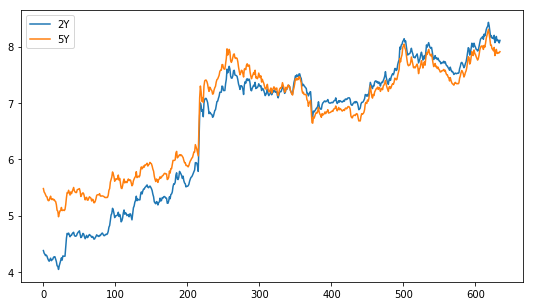

In [7]:
pd.concat([data['2Y'],data['5Y']],axis=1).plot(figsize=(9,5))

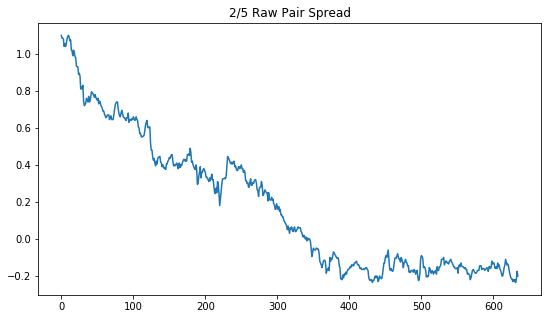

In [8]:
dfpairs['2/5'].plot(figsize=(9,5)) # Plot Pair Spread
plt.title('2/5 Raw Pair Spread')
plt.show()

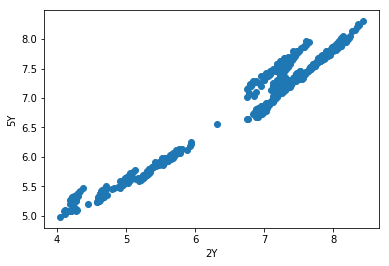

In [9]:
plt.scatter(data['2Y'],data['5Y'])
plt.xlabel('2Y')
plt.ylabel('5Y')
plt.show()

Engle-Granger procedure Step 1.- Fit a linear model to explain 10Y in terms of 5Y, and then apply ADF test on the residual series. 

In [10]:
columns=['Date','2Y','5Y']
dflm25=pd.DataFrame(index=data.index,columns=columns) 
dflm25['Date']=data['Date']
dflm25['2Y']=data['2Y']
dflm25['5Y']=data['5Y']
dflm25.head()

,Date,2Y,5Y
0,04/01/16,4.380,5.48
1,05/01/16,4.335,5.42
2,06/01/16,4.315,5.40
3,07/01/16,4.290,5.37
4,08/01/16,4.300,5.34


In [11]:
X=dflm25['2Y'][1:]
Y=dflm25['5Y'][1:]
X=sm.add_constant(X)
results1=sm.OLS(Y,X).fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                     5Y   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 2.051e+04
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        17:26:03   Log-Likelihood:                 267.95
No. Observations:                 634   AIC:                            -531.9
Df Residuals:                     632   BIC:                            -523.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9238      0.035     55.764      0.0

Beta = 0.7357, so we can calculate Et = 5Y - 0.7357*2Y -1.9238

The second Spread is 5Y vs 10Y:

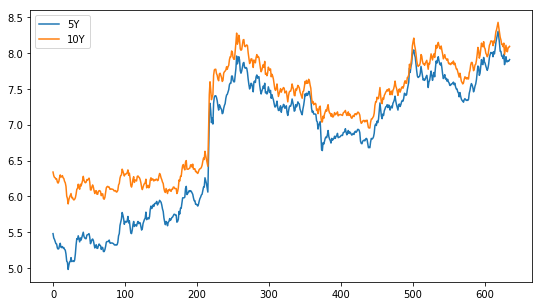

In [12]:
pd.concat([data['5Y'],data['10Y']],axis=1).plot(figsize=(9,5))

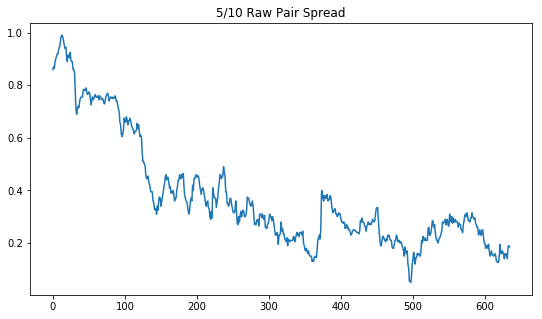

In [13]:
dfpairs['5/10'].plot(figsize=(9,5)) # Plot Pair Spread
plt.title('5/10 Raw Pair Spread')
plt.show()

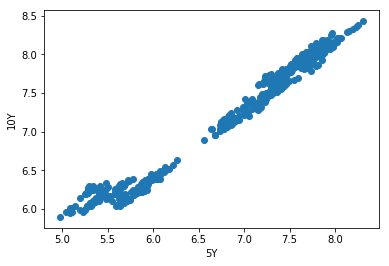

In [14]:
plt.scatter(data['5Y'],data['10Y'])
plt.xlabel('5Y')
plt.ylabel('10Y')
plt.show()

In [15]:
columns=['Date','5Y','10Y']
dflm510=pd.DataFrame(index=data.index,columns=columns) 
dflm510['Date']=data['Date']
dflm510['5Y']=data['5Y']
dflm510['10Y']=data['10Y']
dflm510.head()

,Date,5Y,10Y
0,04/01/16,5.48,6.340
1,05/01/16,5.42,6.290
2,06/01/16,5.40,6.265
3,07/01/16,5.37,6.260
4,08/01/16,5.34,6.240


In [16]:
X=dflm510['5Y'][1:]
Y=dflm510['10Y'][1:]
X=sm.add_constant(X)
results2=sm.OLS(Y,X).fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                    10Y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                 2.869e+04
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        17:26:19   Log-Likelihood:                 504.67
No. Observations:                 634   AIC:                            -1005.
Df Residuals:                     632   BIC:                            -996.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7185      0.032     53.041      0.0

Beta = 0.8019, so we can calculate Et = 10Y - 0.8019*5Y -1.7185

The third Spread is 10Y vs 20Y:

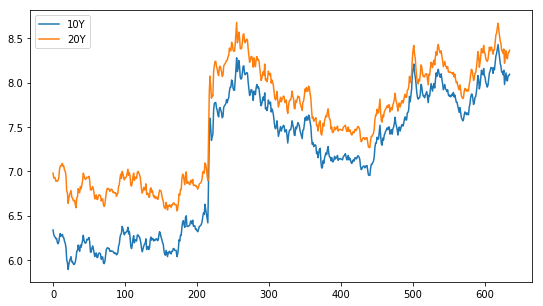

In [17]:
pd.concat([data['10Y'],data['20Y']],axis=1).plot(figsize=(9,5))

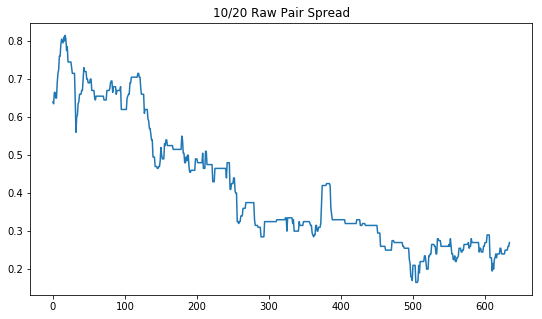

In [18]:
dfpairs['10/20'].plot(figsize=(9,5)) # Plot Pair Spread
plt.title('10/20 Raw Pair Spread')
plt.show()

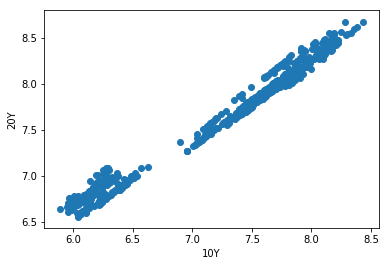

In [19]:
plt.scatter(data['10Y'],data['20Y'])
plt.xlabel('10Y')
plt.ylabel('20Y')
plt.show()

In [20]:
columns=['Date','10Y','20Y']
dflm1020=pd.DataFrame(index=data.index,columns=columns) 
dflm1020['Date']=data['Date']
dflm1020['10Y']=data['10Y']
dflm1020['20Y']=data['20Y']
dflm1020.head()

,Date,10Y,20Y
0,04/01/16,6.340,6.980
1,05/01/16,6.290,6.925
2,06/01/16,6.265,6.930
3,07/01/16,6.260,6.925
4,08/01/16,6.240,6.890


In [21]:
X=dflm1020['10Y'][1:]
Y=dflm1020['20Y'][1:]
X=sm.add_constant(X)
results3=sm.OLS(Y,X).fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                    20Y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 3.218e+04
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        17:26:38   Log-Likelihood:                 668.46
No. Observations:                 634   AIC:                            -1333.
Df Residuals:                     632   BIC:                            -1324.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7759      0.032     54.722      0.0

Beta = 0.8091, so we can calculate Et = 10Y - 0.8091*5Y -1.7759

# ADF tests:

Now we have defined a stationary_test() function for executing ADF tests and present results in a table.

In [22]:
def stationary_test(df):
    print('Results of Dickey-Fuller Test:')
    df_test=adfuller(df)
    indices = ['Test Statistic', 'p-value', 'No. Lags Used', 'Number of Observations Used']
    output = pd.Series(df_test[0:4], index=indices) # 4 lags for quarterly, 12 for monthly
    for key, value in df_test[4].items():
        output['Critical value (%s)' % key] = value
    print(output)

Now lets define the linear model for calculating Et and then testing ADF on Et for the Spread #1:

In [27]:
MiuE=results1.params['const'] 
Beta=results1.params['2Y']
print(MiuE)
print(Beta)

1.923847927876264
0.7356831234385689


In [28]:
dflm25['Et']=dflm25['5Y']-Beta*dflm25['2Y']-MiuE 
dflm25.head()

,Date,2Y,5Y,Et
0,04/01/16,4.380,5.48,0.333860
1,05/01/16,4.335,5.42,0.306966
2,06/01/16,4.315,5.40,0.301679
3,07/01/16,4.290,5.37,0.290071
4,08/01/16,4.300,5.34,0.252715


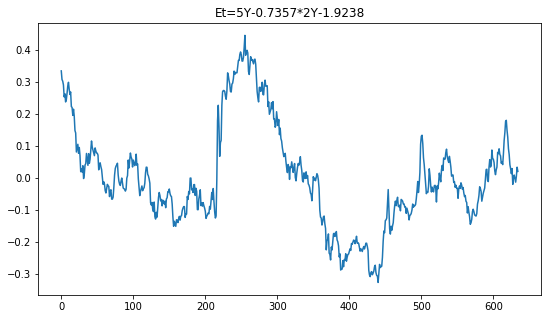

In [29]:
dflm25['Et'].plot(figsize=(9,5)) # Plot the Residual series
plt.title('Et=5Y-0.7357*2Y-1.9238')
plt.show()

In [30]:
stationary_test(dflm25['Et'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.420911
p-value                          0.135921
No. Lags Used                    3.000000
Number of Observations Used    631.000000
Critical value (1%)             -3.440756
Critical value (5%)             -2.866131
Critical value (10%)            -2.569215
dtype: float64


We can not reject Ho: Unit Root Existance, p-value is > 0.05, Et for the first Spread is not stationary on the long term.

In [31]:
MiuE=results2.params['const'] 
Beta=results2.params['5Y']
print(MiuE)
print(Beta)

1.7184756880868435
0.8019132228456274


In [33]:
dflm510['Et']=dflm510['10Y']-Beta*dflm510['5Y']-MiuE 
dflm510.head()

,Date,5Y,10Y,Et
0,04/01/16,5.48,6.340,0.227040
1,05/01/16,5.42,6.290,0.225155
2,06/01/16,5.40,6.265,0.216193
3,07/01/16,5.37,6.260,0.235250
4,08/01/16,5.34,6.240,0.239308


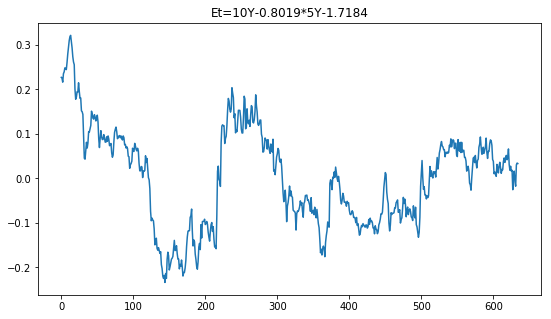

In [34]:
dflm510['Et'].plot(figsize=(9,5)) # Plot the Residual series
plt.title('Et=10Y-0.8019*5Y-1.7184')
plt.show()

In [62]:
stationary_test(dflm510['Et'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.883856
p-value                          0.047258
No. Lags Used                    1.000000
Number of Observations Used    633.000000
Critical value (1%)             -3.440723
Critical value (5%)             -2.866117
Critical value (10%)            -2.569207
dtype: float64


We can reject Ho: Unit Root Existance with 95% confidence, p-value is < 0.05, Et for the second Spread is a potentially stationary on the long term.

In [36]:
MiuE=results3.params['const'] 
Beta=results3.params['10Y']
print(MiuE)
print(Beta)

1.775925109815792
0.8091435411061837


In [38]:
dflm1020['Et']=dflm1020['20Y']-Beta*dflm1020['10Y']-MiuE 
dflm1020.head()

,Date,10Y,20Y,Et
0,04/01/16,6.340,6.980,0.074105
1,05/01/16,6.290,6.925,0.059562
2,06/01/16,6.265,6.930,0.084791
3,07/01/16,6.260,6.925,0.083836
4,08/01/16,6.240,6.890,0.065019


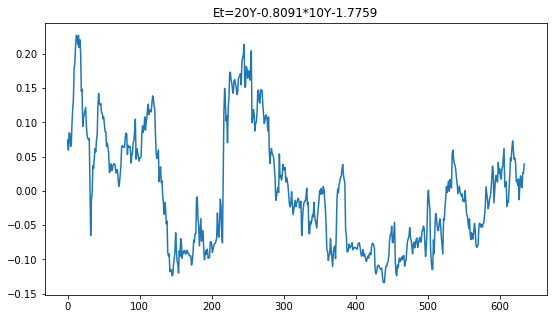

In [63]:
dflm1020['Et'].plot(figsize=(9,5)) # Plot the Residual series
plt.title('Et=20Y-0.8091*10Y-1.7759')
plt.show()

In [40]:
stationary_test(dflm1020['Et'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.971278
p-value                          0.037665
No. Lags Used                    1.000000
Number of Observations Used    633.000000
Critical value (1%)             -3.440723
Critical value (5%)             -2.866117
Critical value (10%)            -2.569207
dtype: float64


We can reject Ho: Unit Root Existance with 95% confidence, for the third Spread Et is potentially stationary.

# 2.2 Test the residual significance using error correction equiation (Both ways) for the potentially Co-integrated Spreads 5/10 and 10/20.

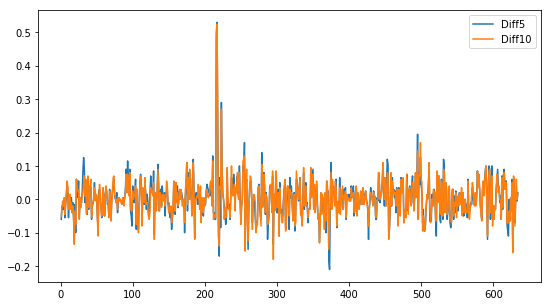

In [48]:
dflm510['Diff5'] = data['5Y'].diff()
dflm510['Diff10'] = data['10Y'].diff()
pd.concat([dflm510['Diff5'],dflm510['Diff10']],axis=1).plot(figsize=(9,5))

In [49]:
dflm510['Et-1'] = dflm510['Et'].shift(1)
dflm510.head()

,Date,5Y,10Y,Et,Diff5,Diff10,Et-1
0,04/01/16,5.48,6.340,0.227040,NaN,NaN,NaN
1,05/01/16,5.42,6.290,0.225155,-0.06,-0.050,0.227040
2,06/01/16,5.40,6.265,0.216193,-0.02,-0.025,0.225155
3,07/01/16,5.37,6.260,0.235250,-0.03,-0.005,0.216193
4,08/01/16,5.34,6.240,0.239308,-0.03,-0.020,0.235250


First test for significance using error correction in the way Diff10 = B1*Diff5 + B2*Et-1

In [51]:
Y=dflm510['Diff10'][1:]
X=dflm510[['Diff5','Et-1']][1:]
X.head()

,Diff5,Et-1
1,-0.060,0.227040
2,-0.020,0.225155
3,-0.030,0.216193
4,-0.030,0.235250
5,-0.005,0.239308


In [52]:
results4=sm.OLS(Y,X).fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:                 Diff10   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     2981.
Date:                Wed, 18 Jul 2018   Prob (F-statistic):          1.48e-322
Time:                        17:59:02   Log-Likelihood:                 1644.1
No. Observations:                 634   AIC:                            -3284.
Df Residuals:                     632   BIC:                            -3275.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Diff5          0.9028      0.012     76.939      0.0

Now Testing the error correction equation on other way Diff5 = B1*Diff10 + B2*Et-1:

In [54]:
Y=dflm510['Diff5'][1:]
X=dflm510[['Diff10','Et-1']][1:]
results5=sm.OLS(Y,X).fit()
print(results5.summary())

                            OLS Regression Results                            
Dep. Variable:                  Diff5   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     2969.
Date:                Wed, 18 Jul 2018   Prob (F-statistic):          4.55e-322
Time:                        18:00:59   Log-Likelihood:                 1611.4
No. Observations:                 634   AIC:                            -3219.
Df Residuals:                     632   BIC:                            -3210.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Diff10         1.0008      0.013     76.939      0.0

Observation: We notice that the residual Et-1 is significant (95% level) in the error correction equation, looks better in the model 10Y is explained by 5Y, the Et-1 t statistic is -2.38 and 1.8238 in the other way. 

Conclusion: Now we can confirm Et is Stationary and then we can use it for pairs trading in the way et=10Y-0.80195Y.

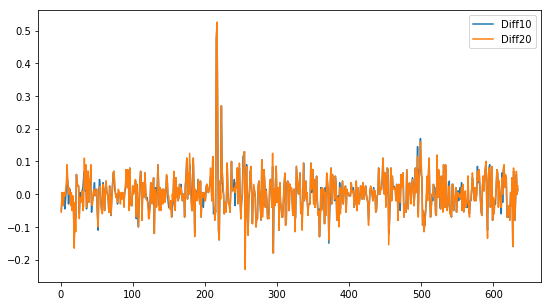

In [55]:
dflm1020['Diff10'] = data['10Y'].diff()
dflm1020['Diff20'] = data['20Y'].diff()
pd.concat([dflm1020['Diff10'],dflm1020['Diff20']],axis=1).plot(figsize=(9,5))

In [56]:
dflm1020['Et-1'] = dflm1020['Et'].shift(1)
dflm1020.head()

,Date,10Y,20Y,Et,Diff10,Diff20,Et-1
0,04/01/16,6.340,6.980,0.074105,NaN,NaN,NaN
1,05/01/16,6.290,6.925,0.059562,-0.050,-0.055,0.074105
2,06/01/16,6.265,6.930,0.084791,-0.025,0.005,0.059562
3,07/01/16,6.260,6.925,0.083836,-0.005,-0.005,0.084791
4,08/01/16,6.240,6.890,0.065019,-0.020,-0.035,0.083836


In [57]:
Y=dflm1020['Diff20'][1:]
X=dflm1020[['Diff10','Et-1']][1:]
X.head()

,Diff10,Et-1
1,-0.050,0.074105
2,-0.025,0.059562
3,-0.005,0.084791
4,-0.020,0.083836
5,0.005,0.065019


In [58]:
results6=sm.OLS(Y,X).fit()
print(results6.summary())

                            OLS Regression Results                            
Dep. Variable:                 Diff20   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     5494.
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        18:07:53   Log-Likelihood:                 1800.2
No. Observations:                 634   AIC:                            -3596.
Df Residuals:                     632   BIC:                            -3588.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Diff10         1.0073      0.010    104.402      0.0

Now Testing the error correction equation on other way Diff10 = B1*Diff20 + B2*Et-1:

In [60]:
Y=dflm1020['Diff10'][1:]
X=dflm1020[['Diff20','Et-1']][1:]
X.head()

,Diff20,Et-1
1,-0.055,0.074105
2,0.005,0.059562
3,-0.005,0.084791
4,-0.035,0.083836
5,0.005,0.065019


In [61]:
results6=sm.OLS(Y,X).fit()
print(results6.summary())

                            OLS Regression Results                            
Dep. Variable:                 Diff10   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     5477.
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        18:10:28   Log-Likelihood:                 1822.7
No. Observations:                 634   AIC:                            -3641.
Df Residuals:                     632   BIC:                            -3633.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Diff20         0.9383      0.009    104.402      0.0

Observation: We notice that the residual Et-1 is significant (95% level) in the error correction equation, looks better in the model 20Y is explained by 10Y, the Et-1 t statistic is -2.212 and 1.745 in the other way. 

Conclusion: Now we can confirm Et is Stationary and then we can use it for pairs trading in the way et=20Y-0.8091*10Y.

# Part 3. OU Calibration for the Strategy design process

Our Strategy will have Entry Rules (if Stationarity exists) defined by certain deviation from the mean for the stationary residual. Then we have to estimate the mean and the standard deviation that applies for the trading logic. We can get thos estimators from the SDE solution of the OU Process, fitting the model Et = C + B*Et-1 + et and use B and C to calculate MiuE=C/(1-B) and SigmaEQ = SigmaOU/sqrt(2Theta).   

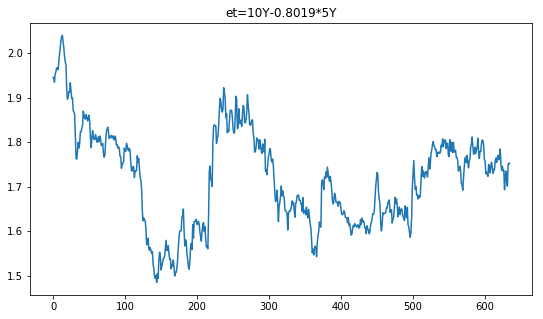

In [80]:
et = data['10Y']-(0.8019*data['5Y'])
Et.plot(figsize=(9,5)) # Plot the Spread Et series
plt.title('et=10Y-0.8019*5Y')
plt.show()

In [81]:
Y = et[1:]
Y.head()

1    1.943702
2    1.934740
3    1.953797
4    1.957854
5    1.966864
dtype: float64

In [82]:
X = Y.shift(1)
X=X[1:]
X.head()

2    1.943702
3    1.934740
4    1.953797
5    1.957854
6    1.966864
dtype: float64

In [83]:
Y = Y[1:]
Y.head()

2    1.934740
3    1.953797
4    1.957854
5    1.966864
6    1.965968
dtype: float64

In [85]:
X.name='et-1'
Y.name='et'
X.head()

2    1.943702
3    1.934740
4    1.953797
5    1.957854
6    1.966864
Name: et-1, dtype: float64

In [86]:
Y.head()

2    1.934740
3    1.953797
4    1.957854
5    1.966864
6    1.965968
Name: et, dtype: float64

In [87]:
X=sm.add_constant(X)
X.head()

,const,et-1
2,1.0,1.943702
3,1.0,1.934740
4,1.0,1.953797
5,1.0,1.957854
6,1.0,1.966864


Now lets fit the model et=C+B*et-1+errort

In [88]:
results=sm.OLS(Y,X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     et   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                 1.980e+04
Date:                Wed, 18 Jul 2018   Prob (F-statistic):               0.00
Time:                        21:38:13   Log-Likelihood:                 1606.1
No. Observations:                 633   AIC:                            -3208.
Df Residuals:                     631   BIC:                            -3199.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0320      0.012      2.666      0.0

In [106]:
C=results.params['const'] 
B=results.params['et-1']
tau = 1/252
MiuE = C/(1-B)
SSE = results.ssr
N = results.nobs
print('MiuE:', MiuE)
print('SSE:',SSE)
print('Nobs:',N)

MiuE: 1.702407847003383
SSE: 0.2318019684597201
Nobs: 633.0


In [73]:
theta = -np.log(B)/tau
theta

4.784670432039405

In [74]:
yrfraction=np.log(2)/theta
yrfraction

0.1448683227832058

In [76]:
workdays = yrfraction/tau
workdays

36.506817341367864

In [77]:
exp = math.exp(-2*theta*tau)

In [113]:
sde = et[1:] - B*X['et-1']-C
sder = sde[1:]
std = np.std(sder)
STD = np.sqrt(SSE/(N-1))
SigmaOU = STD*np.sqrt(-2*np.log(B)/(tau*(1-(B**2))))
print('SigmaOU:',SigmaOU)

SigmaOU: 0.306909387778841


In [104]:
SigmaEQ = SigmaOU/np.sqrt(2*theta)
print('SigmaEQ:',SigmaEQ)

SigmaEQ: 0.09913473379152714


In [105]:
print('OU Stochastic Process calibration variables:')
print('C parameter       ', round(C,4))
print('B parameter       ', round(B,4))
print('Theta             ', round(theta,2))
print('Half-life (Yrfrac)', round(yrfraction,4))
print('Half-life (wdays) ', round(workdays,0))
print('MiuE              ', round(MiuE,2))
print('Sigma OU          ', round(SigmaOU,4))
print('Sigma EQ          ', round(SigmaEQ,4))

OU Stochastic Process calibration variables:
C parameter        0.032
B parameter        0.9812
Theta              4.78
Half-life (Yrfrac) 0.1449
Half-life (wdays)  37.0
MiuE               1.7
Sigma OU           0.3067
Sigma EQ           0.0991


Now we have calculated MiuE = -0.0160041 and SigmaEQ = 2.499453 we can define our entry rules in the way: IF Et>(MiuE+(Z*SigmaEQ)) THEN we are going to enter the market Receiving 10Y and Paying the 0.8019*5Y, IF Et<(MiuE-(Z*SigmaEQ)) THEN we are goin to enter the market Paying 10Y and Receiving 0.8019*5Y where Z will be founded in the Backtesting Optimization work. 

Backtesting and Results will be showed in CQF_Final_Project.py